# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Kaggle Assignment: **

**Student Name: Jason Walker**

# Overview

## Description
This is one of the projects from the course T81-855: Applications of Deep Learning at Washington University in St. Louis. All students must create a Kaggle account and submit a solution. Once you have submitted your solution entry log into Blackboard (at WUSTL) and submit a single file telling me your Kaggle name on the leaderboard (you do not need to register to Kaggle with your real name). This competition will be visible to the public, so there may be non-student submissions as well as student.

The data set for this competition consists of a number of input columns that should be used to predict a stores sales. This is a regression problem. The inputs are a mixture of discrete and category values. The data set is from a simulation.

## Evaluation

The evaluation pages describes how submissions will be scored and how students should format their submissions. The scores are in RMSE.
Submission Format

For every store in the dataset, submission files should contain a sales volume.

The file should contain a header and have the following format:

```
100000,1.23
100001,1.123
100002,3.332
100003,1.53
...
```

# Data

## Data Description

The data contains data and costs for various office supplies. The data came from a simulation and do not directly correspond to any real-world items. See how well you can predict the cost of an item using the provided data. Feature engineering will likely help you. The *name* column may seem useless at first glance; however, it contains information that you can parse to help your predictions.
File descriptions
```
    id - The identifier/primary key.
    name - The name of this item.
    manufacturer - The manufacturer.
    pack - The number of items in this pack.
    weight - The weight of a pack of these items.
    height - The height of a pack of these items.
    width - The width of a pack of these items.
    length - The length of a pack of these items.
    cost - The cost for this item pack. This is what you are to predict (the target). 
```

# Helpful Functions

You will see these at the top of every module and assignment.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [36]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Kaggle Code



In [37]:
import os
import re
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

path = './data'

filename_test = os.path.join(path,"test.csv")
filename_train = os.path.join(path,"train.csv")
filename_sample = os.path.join(path,"sample.csv")
filename_submit = os.path.join(path,"submit.csv")
filename_checkpoint = os.path.join(path,"checkpoint.hdf5")

df_train = pd.read_csv(filename_train,na_values=['NA','?'])

np.random.seed(42) # Uncomment this line to get the same shuffle each time
df_train = df_train.reindex(np.random.permutation(df_train.index))
df_train.reset_index(inplace=True, drop=True)

# Encode Features

# Remove all rows where the specified column is +/- sd standard deviations
def extract_and_encode_features(df):
    color_regex='(?P<color>red|blue|green|yellow|orange|pink|black|brown|white)'
    df['color'] = df.name.str.extract(color_regex, flags=re.IGNORECASE, expand=False)

    quality_regex='(?P<quality>generic|medium\shigh\squality|high\squality)'
    df['quality'] = df.name.str.extract(quality_regex, flags=re.IGNORECASE, expand=False)

    size_regex='(?P<size>tiny|small|medium|large)'
    df['size'] = df.name.str.extract(size_regex, flags=re.IGNORECASE, expand=False)

    item_regex='(?P<item>paperclips|paperweights|ink\spens|pencils|stapler|tablets|thumbtacks|post\sit\snotes)'
    df['item'] = df.name.str.extract(item_regex, flags=re.IGNORECASE, expand=False)
    
    for column in ['pack','weight','height','width','length']:
        missing_median(df,column)
    
    df.insert(1,'surface_area',(df['height']*df['width']*df['length']).astype(int))
    
    ## encode numeric features
    for column in ['pack','weight','height','width','length','surface_area']:
        encode_numeric_zscore(df,column)
     
    # encode text/categorical features
    for column in ['manufacturer','color','quality','size','item']:
        encode_text_dummy(df,column)
  

extract_and_encode_features(df_train)
ids_train = df_train['id']
df_train.drop('id',1,inplace=True)

names_train = df_train['name']
df_train.drop('name',1,inplace=True)

x,y = to_xy(df_train,'cost')
# Cross-Validate
kf = KFold(5)

# Used before KFold
#x_train, x_test, y_train, y_test = train_test_split(    
#    x, y, test_size=0.25, random_state=45)



Final score (RMSE): 32.574493408203125
['surface_area', 'pack', 'weight', 'height', 'width', 'length', 'manufacturer-6% Solution', 'manufacturer-Deep Office Supplies', 'manufacturer-Duck Lake', 'manufacturer-Offices-R-Us', 'manufacturer-WizBang', 'color-Black', 'color-Blue', 'color-Brown', 'color-Green', 'color-Pink', 'color-Red', 'color-White', 'quality-Generic', 'quality-High Quality', 'quality-Medium High Quality', 'size-Large', 'size-Medium', 'size-Small', 'size-Tiny', 'item-Ink Pens', 'item-Paperclips', 'item-Paperweights', 'item-Pencils', 'item-Post It Notes', 'item-Stapler', 'item-Tablets', 'item-Thumbtacks']


,coef,positive
width,-59325.632812,False
length,-42621.746094,False
color-Red,-39.872803,False
color-Green,-27.151611,False
color-Blue,-13.093750,False
size-Tiny,-4.372559,False
quality-Generic,-3.246094,False
color-Brown,-1.934448,False
pack,-1.032338,False
size-Small,0.523438,True


Intercept: [-45641.23046875]


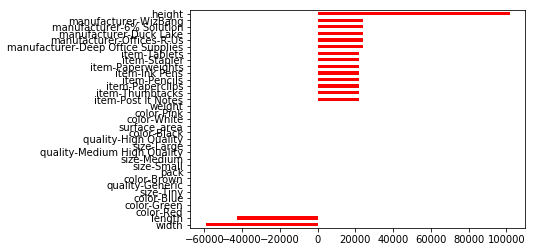

In [38]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
print(names)
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

In [39]:
oos_y = []
oos_pred = []
fold = 0
checkpoint = ModelCheckpoint(filepath=filename_checkpoint, verbose=0, save_best_only=True)
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dropout(0.01)) # Dropout Layer
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(10, 
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01),activation='relu')) # Hidden 3 w/regularization
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=0,epochs=1000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


Fold #1
Epoch 00457: early stopping
Fold score (RMSE): 12.495246887207031
Fold #2
Epoch 00351: early stopping
Fold score (RMSE): 12.528682708740234
Fold #3
Epoch 00341: early stopping
Fold score (RMSE): 12.405563354492188
Fold #4
Epoch 00379: early stopping
Fold score (RMSE): 11.189557075500488
Fold #5
Epoch 00340: early stopping
Fold score (RMSE): 11.839719772338867


In [40]:
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score)) 

Final, out of sample score (RMSE): 12.10274600982666


In [41]:
model.load_weights(filename_checkpoint)
pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

#chart_regression(pred.flatten(),y_test)
#chart_regression(pred.flatten(),y_test,sort=False)

Final score (RMSE): 8.069520950317383


In [42]:
df_test = pd.read_csv(filename_test,na_values=['NA','?'])

extract_and_encode_features(df_test)

ids_test = df_test['id']
df_test.drop('id',1,inplace=True)

names_test = df_test['name']
df_test.drop('name',1,inplace=True)

x_submit = df_test.as_matrix().astype(np.float32)
pred_submit = model.predict(x_submit)


In [43]:
cost = [n if n > 0 else 0 for n in pred_submit[:,0]]
df_submit = pd.DataFrame({'id': ids_test,'cost': cost})
df_submit = df_submit[['id', 'cost']]
df_submit.to_csv(filename_submit, index=False)